In [1]:
import sys
sys.path.append('../') # or just install the module
sys.path.append('../../flaming-choripan') # or just install the module
sys.path.append('../../astro-lightcurves-handler') # or just install the module

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
==============================linear-fstw
Confusion matrix. Using 102 astrophysical features ($\mu\pm\sigma$ from 0 k-fold in test-set)


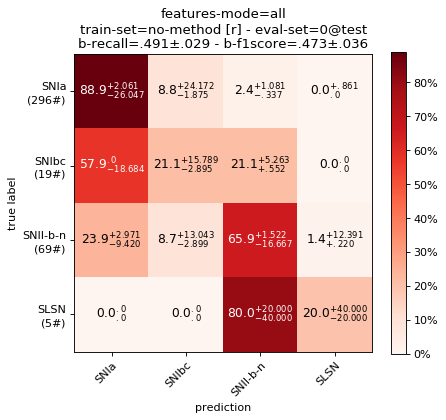

Confusion matrix. Using 102 astrophysical features ($\mu\pm\sigma$ from 0 k-fold in test-set)


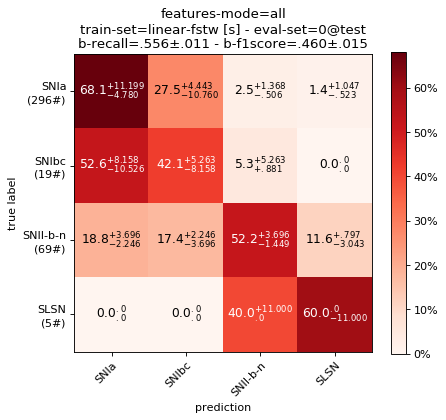

Confusion matrix. Using 102 astrophysical features ($\mu\pm\sigma$ from 0 k-fold in test-set)


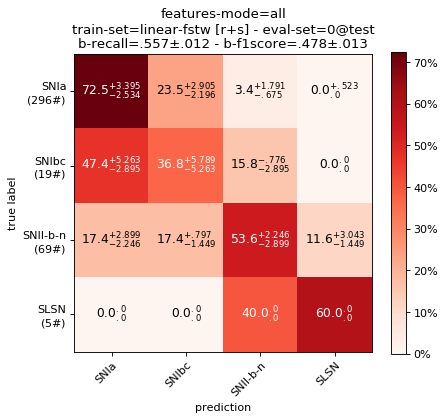

==============================bspline-fstw
Confusion matrix. Using 102 astrophysical features ($\mu\pm\sigma$ from 0 k-fold in test-set)


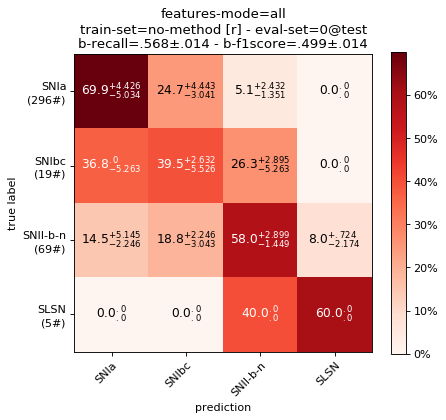

Confusion matrix. Using 102 astrophysical features ($\mu\pm\sigma$ from 0 k-fold in test-set)


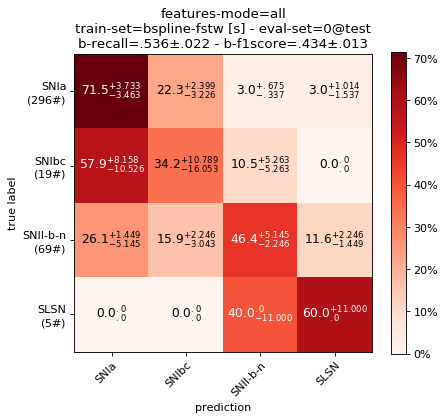

Confusion matrix. Using 102 astrophysical features ($\mu\pm\sigma$ from 0 k-fold in test-set)


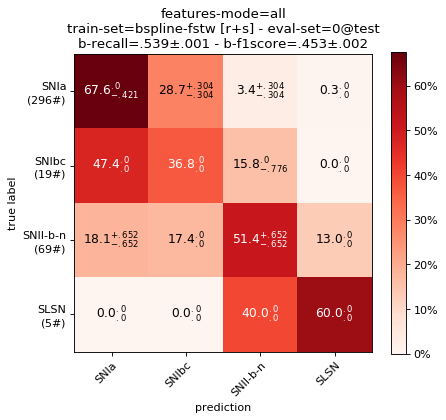

==============================spm-mcmc-fstw


KeyError: 'test'

In [50]:
%load_ext autoreload
%autoreload 2
import numpy as np
from flamingchoripan.files import search_for_filedirs, gather_files_by_kfold
from flamingchoripan.cuteplots.cm_plots import plot_custom_confusion_matrix
import matplotlib.pyplot as plt
from flamingchoripan.datascience.xerror import XError
from IPython.display import display

def get_kf_text(set_name, kf):
    if kf=='.':
        return f'($\\mu\\pm\\sigma$ from 5-fold cross-validation in {set_name}-set)'
    else:
        return f'($\\mu\\pm\\sigma$ from {kf} k-fold in {set_name}-set)'

def get_mode_text(mode, features):
    if mode=='sne':
        return f'Using {len(features)} SNe selected astrophysical features'
    else:
        return f'Using {len(features)} astrophysical features'
    
mode = 'all' # all sne
methods = [
    'linear-fstw',
    'bspline-fstw',
    #'spm-mle-fstw',
    'spm-mcmc-fstw',
    #'spm-mle-estw',
    'spm-mcmc-estw',
]
#methods = ['spm-mcmc-estw']
eval_lcset_name = 'test'
kf = '0'

for method in methods:
    print('='*30+method)
    #for train_config in ['r', 's']:
    for train_config in ['r', 's', 'r+s']:
        rootdir = f'../save/exp=rf_eval~train_config={train_config}~mode={mode}/survey=alerceZTFv7.1~bands=gr~mode=onlySNe~method={method}'
        files, files_ids = gather_files_by_kfold(rootdir, kf, eval_lcset_name)
        class_names = files[0]()['lcset_info']['class_names']
        features = files[0]()['features']
        cms = np.concatenate([f()['cm'][None] for f in files], axis=0)
        bprecision_xe = XError([f()['metrics_dict']['b-precision'] for f in files])
        brecall_xe = XError([f()['metrics_dict']['b-recall'] for f in files])
        bf1score_xe = XError([f()['metrics_dict']['b-f1score'] for f in files])

        ### plot cm
        _title = 'no-method [r]' if train_config=='r' else f'{method} [{train_config}]'
        title = ''
        title += f'features-mode={mode}'+'\n'
        title += f'train-set={_title} - eval-set={kf}@{eval_lcset_name}'+'\n'
        #title += f'b-p/r={bprecision_xe} / {brecall_xe}'+'\n'
        #title += f'b-f1score={bf1score_xe}'+'\n'
        title += f'b-recall={brecall_xe} - b-f1score={bf1score_xe}'+'\n'
        cm_kwargs = {
            'title':title[:-1],
            'figsize':(6,5),
            'new_order_classes':['SNIa', 'SNIbc', 'SNII-b-n', 'SLSN'],
        }
        fig, ax, cm_norm = plot_custom_confusion_matrix(cms, class_names, **cm_kwargs)
        #accu = XError(np.diagonal(cm_norm*100, axis1=1, axis2=2).flatten().tolist())
        #title += f'b-accu={accu}'+'\n'
        #ax.set_title(title[:-1])
        caption = ''
        caption += f'Confusion matrix.'
        caption += f' {get_mode_text(mode, features)} {get_kf_text(eval_lcset_name, kf)}'
        print(caption)
        plt.show()

In [5]:
%load_ext autoreload
%autoreload 2
import numpy as np
from flamingchoripan.files import load_pickle, save_pickle
from flamingchoripan.datascience.xerror import XError
from flamingchoripan.dataframes import DFBuilder
from flamingchoripan.latex.latex_tables import LatexTable

dmetrics = {
    f'b-precision':{'k':1, 'mn':None},
    f'b-recall':{'k':1, 'mn':None},
    f'b-f1score':{'k':1, 'mn':None},
    f'b-rocauc':{'k':1, 'mn':'b-AUCROC'},
    #f'b-prauc':{'k':1, 'mn':'b-AUCPR'},
    }
info_df = DFBuilder()
for train_config in ['r', 's', 'r+s']:
    aux_r = []
    for method in methods:
        d = {}
        for metric in dmetrics.keys():
            mn = metric if dmetrics[metric]['mn'] is None else dmetrics[metric]['mn']
            rootdir = f'../save/exp=rf_eval~train_config={train_config}~mode={mode}/survey=alerceZTFv7.1~bands=gr~mode=onlySNe~method={method}'
            files, files_ids = gather_files_by_kfold(rootdir, kf, eval_lcset_name)
            class_names = files[0]()['lcset_info']['class_names']
            features = files[0]()['features']
            metric_xe = XError([f()['metrics_dict'][metric]*dmetrics[metric]['k'] for f in files])
            d[mn] = metric_xe
            #print(len(metric_xe))
        
        if not train_config=='r': # mean across methods in real case
            info_df.append(f'synthetic-method={method} [{train_config}]', d)
        else:
            aux_r.append(d)

    if train_config=='r': # mean across methods in real case
        for r in aux_r:
            print(r)
        new_d = {k:sum([r[k] for r in aux_r]) for k in d.keys()}
        info_df.append(f'synthetic-method=no-method [{train_config}]', new_d)
            
display(info_df())
caption = ''
caption += f'Synthetic generation methods scores using only real samples [r], only synthetic samples [s], and the same proportion of real and synthetic samples [r+s].'
caption += f' {get_mode_text(mode, features)} {get_kf_text(eval_lcset_name, kf)}'

latex_kwargs = {
    'caption':caption,
    'label':'?',
    #'bold_axis':'columns',
}
latex_table = LatexTable(info_df(), **latex_kwargs)
print(latex_table)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
{'b-precision': .499±.020, 'b-recall': .556±.023, 'b-f1score': .505±.019, 'b-AUCROC': .810±.008}
{'b-precision': .490±.017, 'b-recall': .542±.032, 'b-f1score': .496±.021, 'b-AUCROC': .810±.011}
{'b-precision': .492±.013, 'b-recall': .545±.022, 'b-f1score': .496±.015, 'b-AUCROC': .818±.008}
{'b-precision': .502±.013, 'b-recall': .560±.030, 'b-f1score': .508±.016, 'b-AUCROC': .815±.012}


,b-precision,b-recall,b-f1score,b-AUCROC
synthetic-method=no-method [r],.496±.017,.551±.028,.501±.019,.813±.010
synthetic-method=linear-fstw [s],.479±.015,.552±.033,.465±.017,.804±.009
synthetic-method=bspline-fstw [s],.475±.014,.533±.042,.449±.016,.788±.016
synthetic-method=spm-mcmc-fstw [s],.486±.014,.558±.027,.473±.015,.809±.006
synthetic-method=spm-mcmc-estw [s],.499±.013,.567±.018,.488±.015,.807±.012
synthetic-method=linear-fstw [r+s],.491±.011,.573±.010,.489±.012,.810±.008
synthetic-method=bspline-fstw [r+s],.490±.014,.558±.026,.482±.018,.807±.013
synthetic-method=spm-mcmc-fstw [r+s],.482±.018,.559±.032,.480±.021,.813±.006
synthetic-method=spm-mcmc-estw [r+s],.485±.010,.552±.024,.480±.016,.813±.013


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
\def\srule{\rule{0pt}{2ex}\rule[-1ex]{0pt}{0ex}}
\begin{table*}
\centering
\caption{Synthetic generation methods scores using only real samples [r], only synthetic samples [s], and the same proportion of real and synthetic samples [r+s]. Using 102 astrophysical features ($\mu\pm\sigma$ from 0 k-fold in test-set)}
\label{?}\vspace{.1cm}
\begin{tabular}{l|cccc}
\hline
synthetic-method & b-precision & b-recall & b-f1score & b-AUCROC \srule\\\hline\hline
no-method [r] & .496$\pm$.017 & .551$\pm$.028 & .501$\pm$.019 & .813$\pm$.010  \srule\\
linear-fstw [s] & .479$\pm$.015 & .552$\pm$.033 & .465$\pm$.017 & .804$\pm$.009  \srule\\
bspline-fstw [s] & .475$\pm$.014 & .533$\pm$.042 & .449$\pm$.016 & .788$\pm$.016  \srule\\
spm-mcmc-fstw [s] & .486$\pm$.014 & .558$\pm$.027 & .473$\pm$.015 & .809$\pm$.006  \srule\\
spm-mcmc-estw [s] & .499$\pm$.013 & .567$\pm$.018 & .488$\pm$.015 & .807$\pm$.012  

In [4]:
%load_ext autoreload
%autoreload 2
import numpy as np
from flamingchoripan.files import load_pickle, save_pickle
from flamingchoripan.datascience.xerror import XError
from flamingchoripan.dataframes import DFBuilder
from flamingchoripan.latex.latex_tables import LatexTable

info_df = DFBuilder()
train_config = 'r+s' # r s r+s
rank_n = 10
for k in range(0, rank_n):
    d = {}
    for method in methods:
        rootdir = f'../save/exp=rf_eval~train_config={train_config}~mode={mode}/survey=alerceZTFv7.1~bands=gr~mode=onlySNe~method={method}'
        files, files_ids = gather_files_by_kfold(rootdir, kf, eval_lcset_name)
        class_names = files[0]()['lcset_info']['class_names']
        features = files[0]()['features']
        rank = files[0]()['rank'] # just show one
        feature_name, feature_p,_ = rank[k]
        feature_name = feature_name.replace('_', '-')
        d[f'{method} [{train_config}]'] = f'{feature_name} ({feature_p*100:.2f}%)'

    info_df.append(f'k={k+1}', d)

caption = ''
caption += f'Random Forest astrophysical features ranking (top {rank_n}) using the same proportion of real and synthetic samples [r+s].'
caption += f' {get_mode_text(mode, features)}.'

latex_kwargs = {
    'caption':caption,
    'label':'?',
    #'custom_tabular_align':'l|'+'c'*sum([m.split('-')[-1]=='fstw' for m in methods])+'|'+'c'*sum([m.split('-')[-1]=='estw' for m in methods]),
}
latex_table = LatexTable(info_df(), **latex_kwargs)
print(latex_table)
info_df()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
\def\srule{\rule{0pt}{2ex}\rule[-1ex]{0pt}{0ex}}
\begin{table*}
\centering
\caption{Random Forest astrophysical features ranking (top 10) using the same proportion of real and synthetic samples [r+s]. Using 102 astrophysical features.}
\label{?}\vspace{.1cm}
\begin{tabular}{l|cccc}
\hline
k & linear-fstw [r+s] & bspline-fstw [r+s] & spm-mcmc-fstw [r+s] & spm-mcmc-estw [r+s] \srule\\\hline\hline
1 & SPM-t0-r (4.79\%) & SPM-t0-g (4.86\%) & SPM-t0-g (4.57\%) & SPM-t0-r (5.51\%)  \srule\\
2 & SPM-t0-g (4.07\%) & SPM-gamma-r (3.46\%) & SPM-t0-r (3.84\%) & SPM-t0-g (5.13\%)  \srule\\
3 & SPM-gamma-r (3.25\%) & SPM-t0-r (3.32\%) & SPM-gamma-r (3.55\%) & LinearTrend-r (3.51\%)  \srule\\
4 & LinearTrend-r (3.02\%) & LinearTrend-g (3.20\%) & LinearTrend-g (3.41\%) & SPM-gamma-g (2.63\%)  \srule\\
5 & ExcessVar

,linear-fstw [r+s],bspline-fstw [r+s],spm-mcmc-fstw [r+s],spm-mcmc-estw [r+s]
k=1,SPM-t0-r (4.79%),SPM-t0-g (4.86%),SPM-t0-g (4.57%),SPM-t0-r (5.51%)
k=2,SPM-t0-g (4.07%),SPM-gamma-r (3.46%),SPM-t0-r (3.84%),SPM-t0-g (5.13%)
k=3,SPM-gamma-r (3.25%),SPM-t0-r (3.32%),SPM-gamma-r (3.55%),LinearTrend-r (3.51%)
k=4,LinearTrend-r (3.02%),LinearTrend-g (3.20%),LinearTrend-g (3.41%),SPM-gamma-g (2.63%)
k=5,ExcessVar-r (2.92%),SPM-gamma-g (3.07%),LinearTrend-r (2.88%),SPM-gamma-r (2.40%)
k=6,LinearTrend-g (2.88%),LinearTrend-r (2.95%),SPM-gamma-g (2.72%),SPM-tau-fall-r (2.39%)
k=7,SPM-tau-rise-r (2.73%),SPM-tau-rise-r (2.66%),Skew-g (2.31%),LinearTrend-g (2.14%)
k=8,SPM-tau-fall-g (2.42%),Skew-g (2.55%),SPM-tau-fall-g (2.25%),ExcessVar-r (2.12%)
k=9,Meanvariance-r (2.34%),SPM-tau-fall-g (2.34%),SPM-tau-rise-r (1.95%),SPM-tau-rise-r (2.11%)
k=10,SPM-gamma-g (2.32%),ExcessVar-r (2.12%),Meanvariance-r (1.92%),CAR-sigma-g (2.10%)
